# Classsification of Heart Disease

## Introduction
 - provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
- clearly state the question you tried to answer with your project
- identify and describe the dataset that was used to answer the question

## Methods & Results
>- describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.
>- your report should include code which:
    - loads data from the original source on the web 
    - wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
    - performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
    - creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
    - performs the data analysis
    - creates a visualization of the analysis 
    - note: all tables and figure should have a figure/table number and a legend

In [29]:
# Load libraries
library(tidyverse)
library(repr)
library(tidymodels)

### Initial Data Cleaning
First, we must download the dataset from the web into R. Since the dataset has no column names, they must be manually set in accordance with the [dataset website](https://archive.ics.uci.edu/ml/datasets/Heart+Disease).

In [30]:
# Read data from source into R
heart_data_raw <- read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/reprocessed.hungarian.data",
                                delim = " ",
                                col_names = FALSE)
# Map column names
colnames(heart_data_raw) <- c("age", 
                              "sex", 
                              "cp", 
                              "trestbps", 
                              "chol", 
                              "fbs", 
                              "restecg",
                              "thalach", 
                              "exang", 
                              "oldpeak", 
                              "slope", 
                              "ca", 
                              "thal", 
                              "num")
# Preview data
head(heart_data_raw)

Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: " "
dbl (14): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
40,1,2,140,289,0,0,172,0,0.0,-9,-9,-9,0
49,0,3,160,180,0,0,156,0,1.0,2,-9,-9,1
37,1,2,130,283,0,1,98,0,0.0,-9,-9,-9,0
48,0,4,138,214,0,0,108,1,1.5,2,-9,-9,3
54,1,3,150,-9,0,0,122,0,0.0,-9,-9,-9,0
39,1,3,120,339,0,0,170,0,0.0,-9,-9,-9,0


You may notice that some columns have an array of values which seem invalid, such as sex being an integer, or cholesterol levels being -9. This data is thus untidy since the values are not representitive of their actual meanings. First, we will perform the mappings of each column which number their factors (such as sex with 0 meaning female and 1 meaning male).

In [31]:
heart_data_recoded <- heart_data_raw |>
    mutate(sex = recode(sex, 
                        `0` = "female", 
                        `1` = "male")) |>
    mutate(cp = recode(cp, 
                       `1` = "typical angina",
                       `2` = "atypical angina",
                       `3` = "non-anginal pain",
                       `4` = "asymptomatic")) |>
    mutate(fbs = recode(fbs, 
                        `0` = FALSE, 
                        `1` = TRUE)) |>
    mutate(restecg = recode(restecg, 
                            `0` = "normal", 
                            `1` = "abnormality", 
                            `2` = "ventricular hypertrophy")) |>
    mutate(exang = recode(exang, 
                          `0` = FALSE, 
                          `1` = TRUE)) |>
    mutate(slope = recode(slope, 
                          `1` = "upsloping",
                          `2` = "flat",
                          `3` = "downsloping")) |>
    mutate(ca = ifelse(ca < 0, NA, ca)) |>
    mutate(thal = recode(thal, 
                         `3` = "normal", 
                         `6` = "fixed defect", 
                         `7` = "reversable defect")) |>
    mutate(num = recode(num, 
                        `0` = "<50% narrowing", 
                        `1` = ">50% narrowing"))

Warning message:
"There was 1 warning in `mutate()`.
ℹ In argument: `fbs = recode(fbs, `0` = FALSE, `1` = TRUE)`.
Caused by warning:
! Unreplaced values treated as NA as `.x` is not compatible.
Please specify replacements exhaustively or supply `.default`."
Warning message:
"There was 1 warning in `mutate()`.
ℹ In argument: `restecg = recode(restecg, `0` = "normal", `1` = "abnormality",
  `2` = "ventricular hypertrophy")`.
Caused by warning:
! Unreplaced values treated as NA as `.x` is not compatible.
Please specify replacements exhaustively or supply `.default`."
Warning message:
"There was 1 warning in `mutate()`.
ℹ In argument: `exang = recode(exang, `0` = FALSE, `1` = TRUE)`.
Caused by warning:
! Unreplaced values treated as NA as `.x` is not compatible.
Please specify replacements exhaustively or supply `.default`."
Warning message:
"There was 1 warning in `mutate()`.
ℹ In argument: `slope = recode(slope, `1` = "upsloping", `2` = "flat", `3` =
  "downsloping")`.
Caused by warning:

Then, we will replace invalid values (indicated by a -9 or out of range) with NA.

In [32]:
heart_data <- heart_data_recoded |>
    mutate(chol = ifelse(chol < 0, NA, chol)) |>
    mutate(thalach = ifelse(thalach < 0, NA, thalach)) |>
    mutate(age = ifelse(age < 0, NA, age)) |>
    mutate(trestbps = ifelse(trestbps < 0, NA, age))
head(heart_data)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<lgl>,<chr>,<dbl>,<lgl>,<dbl>,<chr>,<dbl>,<chr>,<chr>
40,male,atypical angina,40,289,FALSE,normal,172,FALSE,0.0,NA,NA,NA,<50% narrowing
49,female,non-anginal pain,49,180,FALSE,normal,156,FALSE,1.0,flat,NA,NA,>50% narrowing
37,male,atypical angina,37,283,FALSE,abnormality,98,FALSE,0.0,NA,NA,NA,<50% narrowing
48,female,asymptomatic,48,214,FALSE,normal,108,TRUE,1.5,flat,NA,NA,NA
54,male,non-anginal pain,54,NA,FALSE,normal,122,FALSE,0.0,NA,NA,NA,<50% narrowing
39,male,non-anginal pain,39,339,FALSE,normal,170,FALSE,0.0,NA,NA,NA,<50% narrowing


Now we will split the data into training and testing sets to ensure our analysis and model can be tested against data it has not seen.

In [33]:
heart_data_split <- initial_split(heart_data, prop = 0.7, strata = num)
heart_data_training <- training(heart_data_split)
heart_data_testing <- testing(heart_data_split)

### Exploratory Data Analysis
Now we will get a rough idea of some of the relationships in our data.

First, we will see how many individuals are charactarized with each chest pain type to get an idea of how many symptomatic individuals we are dealing with in the dataset.

In [34]:
chest_pain_counts <- count(heart_data_training, cp) |>
    mutate(total = n) |>
    select(-n)
chest_pain_counts

cp,total
<chr>,<int>
asymptomatic,83
atypical angina,81
non-anginal pain,34
typical angina,7


Next, we will look at the number of regular and irregular ECG readings from individuals in the dataset.

In [35]:
restecg_counts <- count(heart_data_training, restecg) |>
    mutate(total = n) |>
    select(-n)
restecg_counts

restecg,total
<chr>,<int>
abnormality,38
normal,162
ventricular hypertrophy,4
NA,1


Now we will look at only individuals with abnormal ECG results; by contrasting the chest pain type versus the total amount, we can get an idea of relationships between ECG type and chest pain. As well, we will compare the type of chest pain versus the total chest pain count for all individuals.

In [36]:
abnormal_restecg_chest_pain_counts <- heart_data_training |>
    filter(restecg == "abnormality") |>
    count(cp) |>
    bind_cols(select(chest_pain_counts, total)) |>
    mutate(percent_total = n / total * 100)
abnormal_restecg_chest_pain_counts

cp,n,total,percent_total
<chr>,<int>,<int>,<dbl>
asymptomatic,17,83,20.48193
atypical angina,12,81,14.81481
non-anginal pain,7,34,20.58824
typical angina,2,7,28.57143


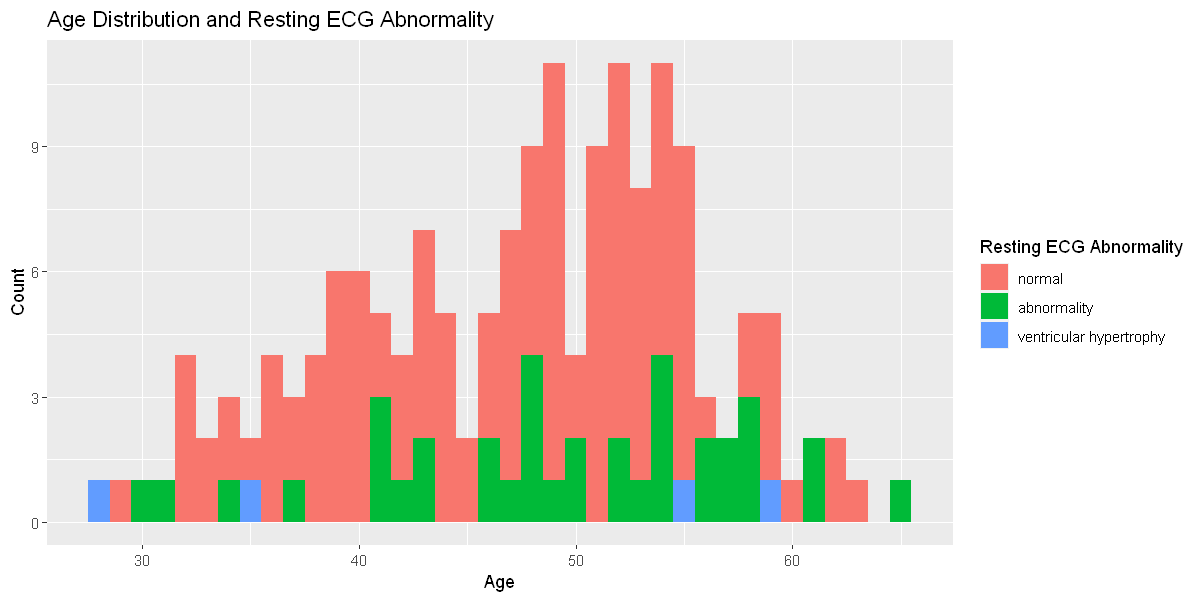

In [37]:
options(repr.plot.height = 5, repr.plot.width = 10)

age_vs_ecg_plot <- heart_data_training |>
    filter(!is.na(restecg)) |>
    ggplot(aes(x = age, fill = as_factor(restecg))) +
    geom_histogram(position = "identity", binwidth = 1) +
    labs(fill = "Resting ECG Abnormality") +
    xlab("Age") +
    ylab("Count") +
    ggtitle("Age Distribution and Resting ECG Abnormality")

age_vs_ecg_plot

A couple things are revealed in this graph; firstly, our dataset is primarily older indivuduals. Second, there appears to be a slight positive correlation between abnormality and age.

Now, we will attempt to see if there is a relationship between serum cholesterol and resting blood pressure. We would expect there to be a positive correlation as there is often a stigma between high cholesterol and high blood pressure. This will be done in a scatterplot:

Warning message:
"Removed 14 rows containing missing values (`geom_point()`)."


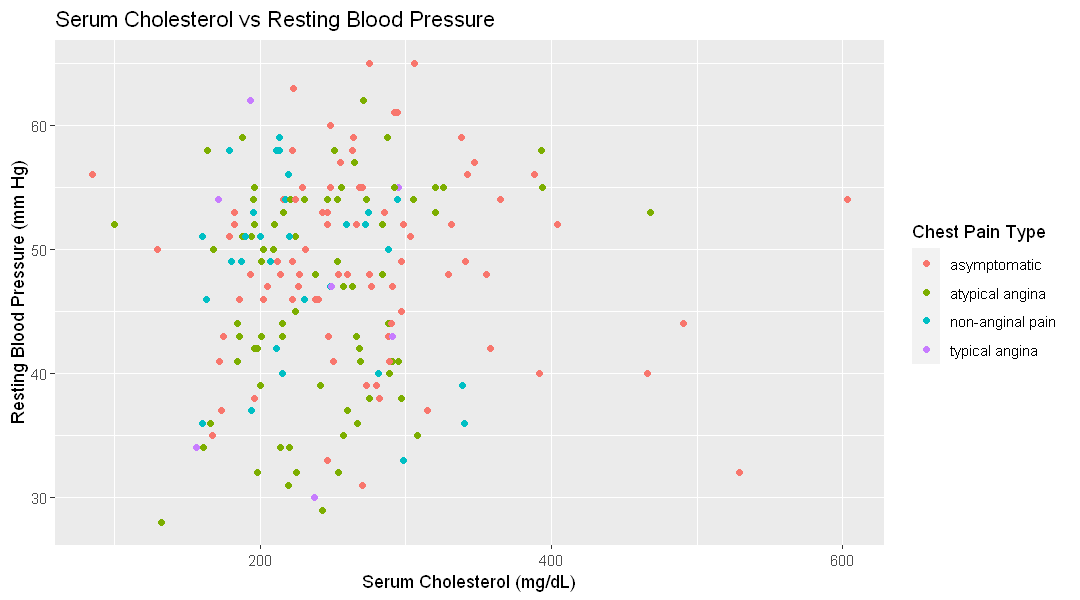

In [38]:
options(repr.plot.height = 5, repr.plot.width = 9)

chol_vs_rhr_plot <- heart_data_training |>
    ggplot(aes(x = chol, y = trestbps, color = cp)) +
    geom_point() +
    xlab("Serum Cholesterol (mg/dL)") +
    ylab("Resting Blood Pressure (mm Hg)") +
    labs(color = "Chest Pain Type") +
    ggtitle("Serum Cholesterol vs Resting Blood Pressure")

chol_vs_rhr_plot

The resulting plot seems somewhat inconlusive, but there may be a slight positive correlation between the two.

## Discussion
- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?

## References
- At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
- Make sure to cite the source of your data as well.